data file
- subjects.pkl
- results_distance.pkl

In [1]:
import os
import csv
import collections
from collections import defaultdict
import pickle


import numpy as np
import pandas as pd



import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

/Users/mialu/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
with open('subjects.pkl','rb') as f:
    subjects = pickle.load(f)
    
subjects = subjects[1:] # remove 200008, which does not exist for some models.

with open('results_distance.pkl','rb') as f:
    results = pickle.load(f)

In [3]:
def getdata(subjects=subjects,results=results):
    pial_rm_res = defaultdict(list)
    pial_res = defaultdict(list)
    for model in ['cortexode', 'corticalflow', 'deepcsr', 'vox2cortex', 'pialnn']:
        for subject in subjects:
            pial_rm_res[model].append(results[subject][model][0][1]) # [0]:pial # [1]: rm
            pial_res[model].append(results[subject][model][0][0])

    white_rm_res = defaultdict(list)
    white_res = defaultdict(list)
    for model in ['cortexode', 'corticalflow', 'deepcsr', 'vox2cortex']:
        for subject in subjects:
            white_rm_res[model].append(results[subject][model][1][1]) 
            white_res[model].append(results[subject][model][1][0])   
    for model in ['topofit']:
        for subject in subjects:
            white_rm_res[model].append(results[subject][model][0][1]) 
            white_res[model].append(results[subject][model][0][0])
    return pial_rm_res, pial_res, white_rm_res, white_res

def get_df(data, surfacename, N = 106):
    # modelnames
    modelname = list(data.keys())
    modelnames = []
    otherdata = collections.defaultdict(list)
    for mn in modelname:
        modelnames += [mn] * 106
        distance_dic_keys = list(data['corticalflow'][0].keys())
        for k in distance_dic_keys:
            otherdata[k] += [data[mn][i][k] for i in range(N)]
    otherdata['modelname'] = modelnames
    otherdata['surface'] = [surfacename] * 530
    df = pd.DataFrame(otherdata)
    df['MaxDiagRatio'] = df['max'] / df['diag_mesh_0']
    replace_dic = {'vox2cortex':'Vox2Cortex','deepcsr':"DeepCSR",
                 'corticalflow':"CorticalFlow",'topofit':"Topofit",
                'cortexode':"CortexODE",'pialnn':"PialNN"}
    df.replace(replace_dic, inplace=True)
    return df



In [4]:
pial_rm_res, pial_res, white_rm_res, white_res = getdata()
df1,df2,df3,df4 = get_df(pial_res,'pial'),get_df(white_res,'white'),get_df(pial_rm_res,'pial'),get_df(white_rm_res,'white')
measure = ['diag_mesh_0', 'max', 'mean','MaxDiagRatio']

plt.rcParams.update({'font.size': 20})
subplot_labels = ['spherical topology','medial wall removed','spherical topology','medial wall removed']

In [5]:
def plot(res,surface,alpha=0.6,showxlabel=False,ylabel=subplot_labels[0]):
    submodel = surface
    i = 1
    plt.figure(figsize=(20,3))
    fig, axs = plt.subplots(nrows = 1, ncols=4)
    fig.set_figwidth(20)
    fig.set_figheight(5)
#     plt.suptitle('Distance measurement of models for lh {}'.format(submodel))
    for m in measure:
        plt.subplot(1,4,i)
        ax = sns.stripplot(data=res, x=m, y=res['modelname'],alpha=alpha, ax = axs[i-1])
        if i > 3:
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_ylabel('')
        if i > 3:
            ax.set_xscale('log')
        if i == 1:
            ax.set_xlim(180,250)
            ax.set_ylabel(ylabel)
            if showxlabel:
                ax.set_xlabel('Diag distance of \ntruth mesh (mm)')
            else:
                ax.set_xlabel('')
        if i == 4:
            ax.set_xlim(0.008,0.2)
            if showxlabel:
                ax.set_xlabel('Ratio of max over diag \ndistance of mesh')
            else:
                ax.set_xlabel('')
        if i == 2:
            ax.set_xlim(0,35)
            if showxlabel:
                ax.set_xlabel('Max distance between\ntruth and predicted (mm)')
            else:
                ax.set_xlabel('')
        if i == 3:
            ax.set_xlim(0,3)
            if showxlabel:
                ax.set_xlabel('Mean distance between\ntruth and predicted (mm)') 
            else:
                ax.set_xlabel('')
        if i > 1:
            ax.set_yticks([])
            
        i += 1
    fig.align_xlabels(axs)

    plt.savefig('lh_{}.png'.format(submodel),dpi=300,transparent=True, bbox_inches='tight', pad_inches=0)
    plt.savefig('distance_{}.svg'.format(submodel), format='svg', transparent=True, bbox_inches='tight', pad_inches=0)

<Figure size 1440x216 with 0 Axes>

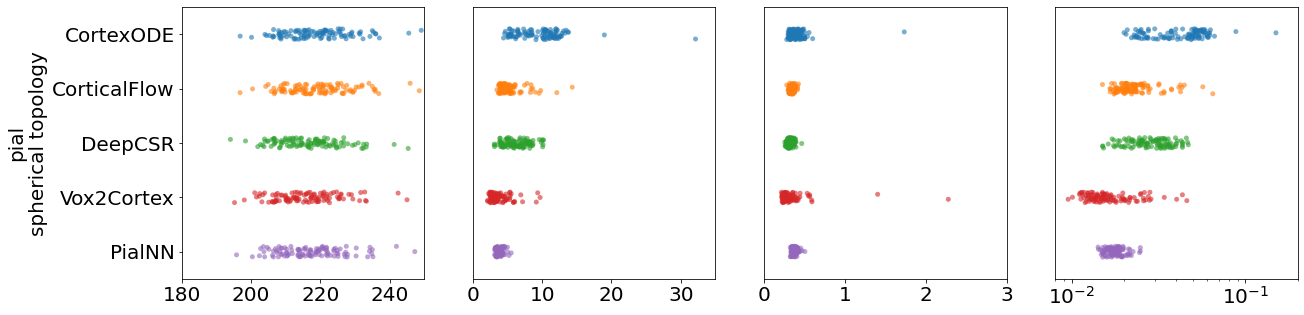

In [6]:
plot(df1,'pial',ylabel='pial\n'+subplot_labels[0])

<Figure size 1440x216 with 0 Axes>

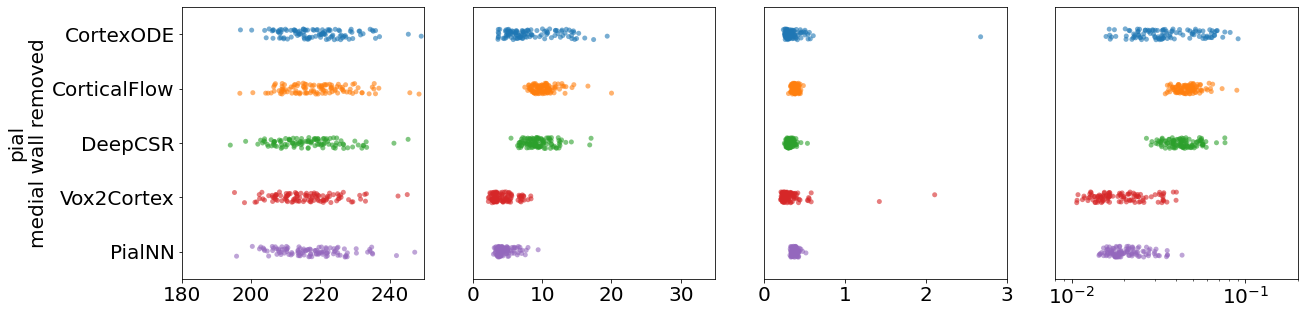

In [7]:
plot(df3,'pial-rm',ylabel='pial\n'+subplot_labels[1])

<Figure size 1440x216 with 0 Axes>

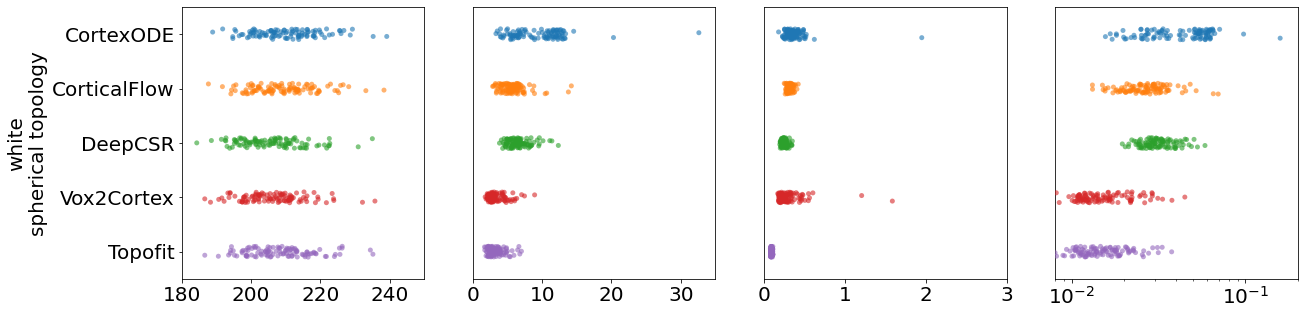

In [8]:
plot(df2, 'white',ylabel='white\n'+subplot_labels[0])

<Figure size 1440x216 with 0 Axes>

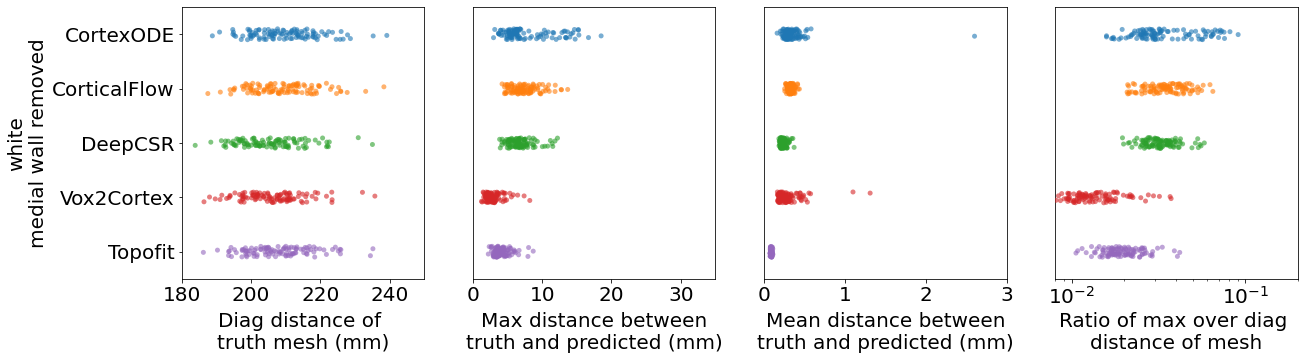

In [9]:
plot(df4, 'white-rm',showxlabel=True,ylabel='white\n'+subplot_labels[1])